In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np

## Train-Val Split
train_kwargs = {
    'root':'../data/',
    'train':True,
    'download':True,
    'transform':transforms.Compose([transforms.ToTensor()]),
}
val_kwargs = {
    'root':'../data/',
    'train':False,
    'download':True,
    'transform':transforms.Compose([transforms.ToTensor()]),
}
train_cifar10 = datasets.CIFAR10(**train_kwargs)
val_cifar10 = datasets.CIFAR10(**val_kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
%load_ext autoreload
%autoreload 2
from datasets import MyDataset
import numpy as np

## Batch Sizes
train_batch_size = 256
val_batch_size = train_batch_size

train_dataset_mnist = MyDataset(train_cifar10.data, train_cifar10.targets, uses_da=True)
val_dataset_mnist = MyDataset(val_cifar10.data, val_cifar10.targets)
val_dataset_mnist.set_norm_values(*train_dataset_mnist.get_norm_values())

print(train_dataset_mnist[0])

x: torch.Size([50000, 3, 32, 32]) - x.max: 1.0 - y: torch.Size([50000]) - y.max: 9
x: torch.Size([10000, 3, 32, 32]) - x.max: 1.0 - y: torch.Size([10000]) - y.max: 9
{'input': {'x': (3, 32, 32)-float32-cpu, 'x2': (32)-float32-cpu}, 'target': {'y': ()-int64-cpu, 'y2': (1)-int64-cpu}}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'input': {'x': (256, 3, 32, 32)-float32-cpu, 'x2': (256, 32)-float32-cpu}, 'target': {'y': (256)-int64-cpu, 'y2': (256, 1)-int64-cpu}}
data torch.Size([256, 3, 32, 32]) cpu torch.float32 tensor(-2.1441) tensor(2.3107)
target torch.Size([256]) cpu torch.int64 tensor(0) tensor(9)
196
40


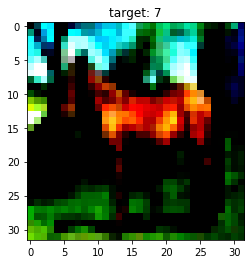

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from fuzzytorch.datasets import tensor_data_collate

## DataLoaders
train_loader_mnist = torch.utils.data.DataLoader(train_dataset_mnist, batch_size=train_batch_size, shuffle=True, collate_fn=tensor_data_collate)
val_loader_mnist = torch.utils.data.DataLoader(val_dataset_mnist, batch_size=val_batch_size, collate_fn=tensor_data_collate)

# print example
for k,tensor_dict in enumerate(train_loader_mnist):
#for k,(data, target) in enumerate(val_loader_mnist):
    print(tensor_dict)
    ind = 37
    data = tensor_dict['input']['x']
    target = tensor_dict['target']['y']
    print('data', data.shape, data.device ,data.dtype, data.min(), data.max())
    print('target', target.shape, target.device, target.dtype, target.min(), target.max())
    img = data[ind].permute(1,2,0).numpy()
    plt.imshow(img)
    plt.title(f'target: {target[ind]}')
    break
    
print(len(train_loader_mnist))
print(len(val_loader_mnist))

# model parameters

In [5]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from flamingchoripan.datascience.grid_search import GDIter, GridSeacher
from baseline_models import MLPClassifier, CNN2DClassifier

mdl_params = {
    #'mdl_class':MLPClassifier,
    'mdl_class':CNN2DClassifier,
    'mdl_kwargs':{
        'dropout':0.5,
        #'dropout':0.0,
        'cnn_features':[16, 32, 64],
        #'cnn_features':[16, 32],
        'uses_mlp_classifier':True,
        #'uses_mlp_classifier':False,
    },
}
gs = GridSeacher(mdl_params)
print(gs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(0) - {'mdl_class': <class 'baseline_models.CNN2DClassifier'>, 'mdl_kwargs': {'dropout': 0.5, 'cnn_features': [16, 32, 64], 'uses_mlp_classifier': True}}



# training

In [ ]:
%load_ext autoreload
%autoreload 2

### LOSS
from fuzzytorch.losses import CrossEntropy

loss_kwargs = {
    'model_output_is_with_softmax':False,
    'target_is_onehot':False,
}
loss = CrossEntropy('x-entropy', **loss_kwargs)

### METRICS
from fuzzytorch.metrics import DummyAccuracy, OnehotAccuracy
metrics = [
    OnehotAccuracy('accuracy', **loss_kwargs),
    DummyAccuracy('dummy-accuracy', **loss_kwargs),
]

from fuzzytorch import C_
trainh_config = {
    'early_stop_epochcheck_epochs':1, # every n epochs check
    #'early_stop_epochcheck_epochs':2, # every n epochs check
    'early_stop_patience_epochchecks':int(1e2),
    #'save_mode':C_.SM_NO_SAVE,
    #'save_mode':C_.SM_ALL,
    #'save_mode':C_.SM_ONLY_ALL,
    #'save_mode':C_.SM_ONLY_INF_METRIC,
    #'save_mode':C_.SM_ONLY_INF_LOSS,
    'save_mode':C_.SM_ONLY_SUP_METRIC,
}
model = mdl_params['mdl_class'](**mdl_params['mdl_kwargs'])

### OPTIMIZER
import torch.optim as optims
from fuzzytorch.optimizers import LossOptimizer

optimizer_kwargs = {
    'opt_kwargs':{
        'lr':1e-3,
    },
    'decay_kwargs':{
        'lr':0.9,
    }
}
optimizer = LossOptimizer(model, optims.Adam, **optimizer_kwargs)

from flamingchoripan.prints import print_bar
from fuzzytorch.handlers import ModelTrainHandler
from fuzzytorch.monitors import LossMonitor

loss_monitors = LossMonitor(loss, optimizer, metrics, **trainh_config)

mtrain_config = {
    'id':0,
    'epochs_max':1e3,
    'save_rootdir':'../save',
}
model_train_handler = ModelTrainHandler(model, loss_monitors, **mtrain_config)
model_train_handler.build_gpu(gpu_index=None)
print(model_train_handler)
model_train_handler.fit_loader(train_loader_mnist, val_loader_mnist)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ml_cnn2d: Conv2D(
  (0) - Conv2DLinear(input_dims=3, input_space=[32, 32], output_dims=16, output_space=[16, 16], spatial_field=[6, 6], cnn_kwargs={'kernel_size': [5, 5], 'stride': [1, 1], 'dilation': [1, 1]}, pool_kwargs={'kernel_size': [2, 2], 'stride': [2, 2], 'dilation': [1, 1]}, padding_mode=same, activation=relu, in_dropout=0.0, out_dropout=0.0, bias=True)(1,216[p])
  (1) - Conv2DLinear(input_dims=16, input_space=[16, 16], output_dims=32, output_space=[8, 8], spatial_field=[6, 6], cnn_kwargs={'kernel_size': [5, 5], 'stride': [1, 1], 'dilation': [1, 1]}, pool_kwargs={'kernel_size': [2, 2], 'stride': [2, 2], 'dilation': [1, 1]}, padding_mode=same, activation=relu, in_dropout=0.0, out_dropout=0.0, bias=True)(12,832[p])
  (2) - Conv2DLinear(input_dims=32, input_space=[8, 8], output_dims=64, output_space=[4, 4], spatial_field=[6, 6], cnn_kwargs={'kernel_size': [5, 5], 'stride': [1, 1], 'dilation': 

In [7]:
%load_ext autoreload
%autoreload 2
# loss_df opt_df loss_df_epoch metrics_df_epoch
loss_monitors.get_time_util_convergence()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: 'LossMonitor' object has no attribute 'get_time_util_convergence'

In [ ]:
# loss_df opt_df loss_df_epoch metrics_df_epoch
loss_monitors.get_save_dict()['opt_df']

In [ ]:
# loss_df opt_df loss_df_epoch metrics_df_epoch
loss_monitors.get_save_dict()['loss_df_epoch']

In [ ]:
# loss_df opt_df loss_df_epoch metrics_df_epoch
loss_monitors.get_save_dict()['metrics_df_epoch']

In [ ]:
%load_ext autoreload
%autoreload 2
from flamingchoripan.counters import Counter

d = {
'val_epoch_counter_duration':1,
'earlystop_epoch_duration':5,
}
c = Counter(d)
for _ in range(50):
    print(c, c.check('earlystop_epoch_duration'))
    c.update()

In [ ]:
%load_ext autoreload
%autoreload 2
import flamingChoripan.tinyFlame.plots as tfplots

### training plots
fig, ax = tfplots.plot_trainloss(train_handler)
fig, ax = tfplots.plot_evaluation_loss(train_handler)
fig, ax = tfplots.plot_evaluation_metrics(train_handler)
#fig, ax = tfplots.plot_optimizer(train_handler, save_dir=mtrain_config['images_save_dir'])
plt.show()
        

# prediction and CM